# Tech Challenger - Fase 01 - Etapa 02 - Contrução do Modelo

Nessa fase vamos captar o que foi feito e escolhido de processamento durante a etapa anterior e vamos a partir disso escolher o modelo.
Nessa etapa podemos até mesmo modificar alguma etapa do pre processamento para melhor ajustar a taxa de acerto.

## Compilando a leitura e processamento da etapa anterior

Unificando o que foi explicado na etapa anterior em um código limp para apenas processar os dados.

In [42]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

import seaborn as sns
import matplotlib.pyplot as plt


In [43]:
data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')
data = data.drop(['sex'], axis='columns')
data.head()

,age,bmi,children,smoker,charges
0,19,27.900,0,yes,16884.92400
1,18,33.770,1,no,1725.55230
2,28,33.000,3,no,4449.46200
3,33,22.705,0,no,21984.47061
4,32,28.880,0,no,3866.85520


<<Explicação>>
A Coluna Região não é relevante para o modelo
A Coluna Sexo não é relevante para o modelo

<<Explicação>>

 Aplicando a Obesidade

 https://www.cancer.org/cancer/risk-prevention/diet-physical-activity/body-weight-and-cancer-risk.html

 IMC entre 25,0 e 29,9 Kg/m2: sobrepeso; 

 IMC entre 30,0 e 34,9 Kg/m2: obesidade grau I; 

 IMC entre 35,0 e 39,9 Kg/m2: obesidade grau II; 

 IMC maior do que 40,0 Kg/m2: obesidade grau III.
 

<Axes: >

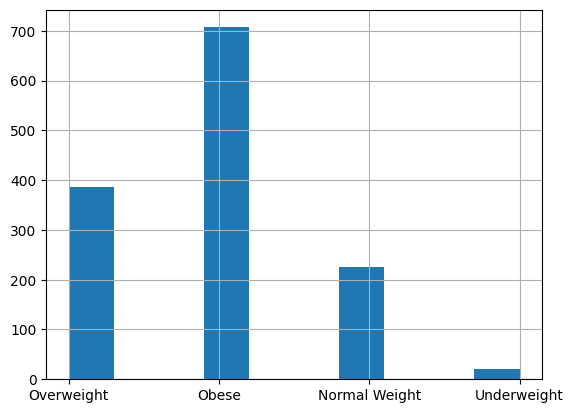

In [44]:
data["weight_condition"] = ""
for col in [data]:
    col.loc[col["bmi"] < 18.5, "weight_condition"] = "Underweight"
    col.loc[(col["bmi"] >= 18.5) & (col["bmi"] < 24.986), "weight_condition"] = "Normal Weight"
    col.loc[(col["bmi"] >= 25) & (col["bmi"] < 29.926), "weight_condition"] = "Overweight"
    col.loc[col["bmi"] >= 30, "weight_condition"] = "Obese"

data["weight_condition"].hist()

<<Explicação>>

<<Explicação>>

In [45]:
# Preparando os dados
numeric_columns = [ 'age', 'bmi', 'children'] # Colunas numéricas
categorical_columns = [ 'smoker', 'weight_condition']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns), # numeric features
        ('cat', OneHotEncoder(), categorical_columns) # categorical features
    ])


base_transformed = preprocessor.fit_transform(data)
base_transformed

array([[-1.43876426, -0.45332   , -0.90861367, ...,  0.        ,
         1.        ,  0.        ],
       [-1.50996545,  0.5096211 , -0.07876719, ...,  1.        ,
         0.        ,  0.        ],
       [-0.79795355,  0.38330685,  1.58092576, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [-1.50996545,  1.0148781 , -0.90861367, ...,  1.        ,
         0.        ,  0.        ],
       [-1.29636188, -0.79781341, -0.90861367, ...,  0.        ,
         1.        ,  0.        ],
       [ 1.55168573, -0.26138796, -0.90861367, ...,  0.        ,
         1.        ,  0.        ]])

In [46]:
base_transformed_df = pd.DataFrame(base_transformed, columns=preprocessor.get_feature_names_out())
data = pd.concat([data['charges'], base_transformed_df], axis=1)
data.head()

,charges,num__age,num__bmi,num__children,cat__smoker_no,cat__smoker_yes,cat__weight_condition_Normal Weight,cat__weight_condition_Obese,cat__weight_condition_Overweight,cat__weight_condition_Underweight
0,16884.92400,-1.438764,-0.453320,-0.908614,0.0,1.0,0.0,0.0,1.0,0.0
1,1725.55230,-1.509965,0.509621,-0.078767,1.0,0.0,0.0,1.0,0.0,0.0
2,4449.46200,-0.797954,0.383307,1.580926,1.0,0.0,0.0,1.0,0.0,0.0
3,21984.47061,-0.441948,-1.305531,-0.908614,1.0,0.0,1.0,0.0,0.0,0.0
4,3866.85520,-0.513149,-0.292556,-0.908614,1.0,0.0,0.0,0.0,1.0,0.0


<<Explicação>>

charges                                1.000000
cat__smoker_yes                        0.787251
num__age                               0.299008
cat__weight_condition_Obese            0.199532
num__bmi                               0.198341
num__children                          0.067998
cat__weight_condition_Underweight     -0.044960
cat__weight_condition_Normal Weight   -0.106265
cat__weight_condition_Overweight      -0.120083
cat__smoker_no                        -0.787251
Name: charges, dtype: float64


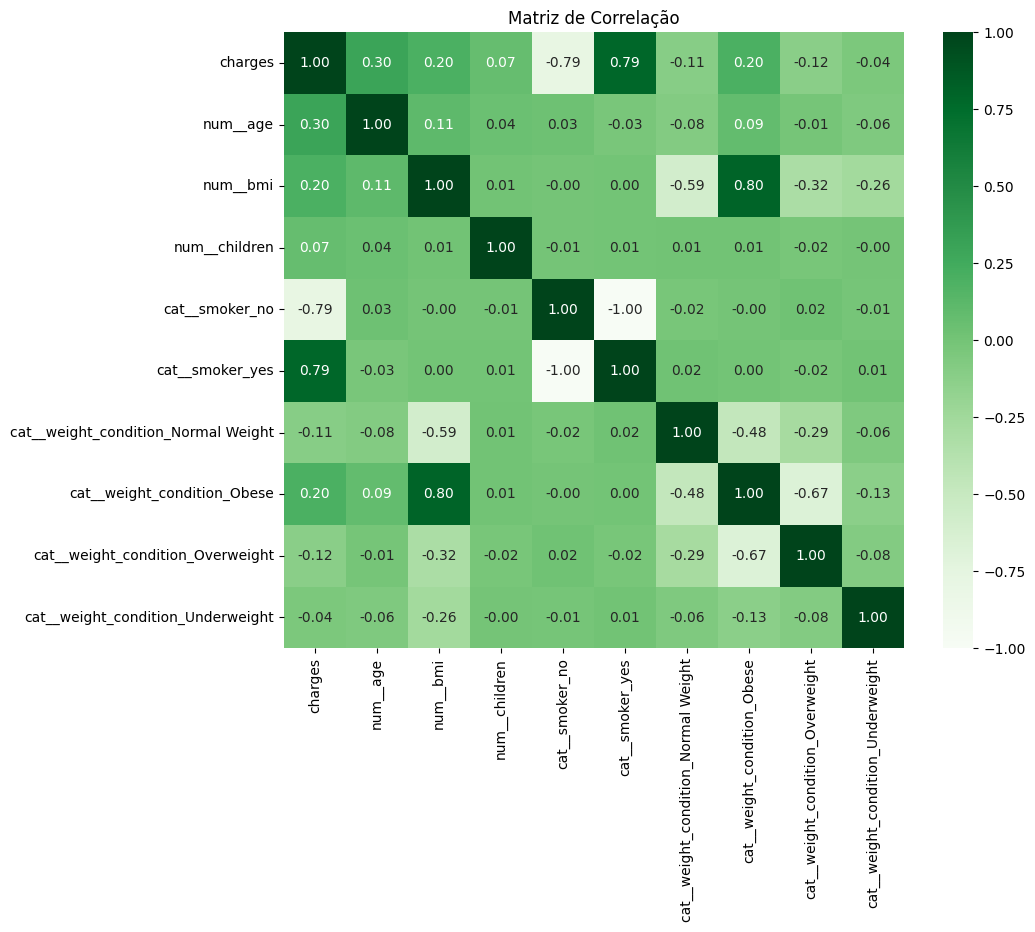

In [47]:
# Matriz de correlação
correlation_matrix = data.corr()
print(correlation_matrix["charges"].sort_values(ascending=False))
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Greens', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()

<<Explicação>>

## Construção do Modelo

Nessa etapa vamos dividir os dados de teste e treinamento e escolher os modelos que podemos utilizar para previsão.

In [48]:
from sklearn.model_selection import train_test_split

In [49]:
X = data.drop(['charges'], axis=1)
y = data['charges']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

<<Explicação>> 

Como avaliar o que está bom ou ruim:
* MSE e MAE:
    * Compare os valores entre os modelos. O modelo com os menores valores de MSE e MAE é o mais preciso.
    * Se os valores forem muito altos, o modelo pode estar subajustado (underfitting).
* R²:
    * Um valor próximo de 1 é desejável.
    * Se o R² for muito baixo, o modelo pode não estar capturando bem os padrões dos dados.
    * Se for muito alto, verifique se o modelo não está superajustado (overfitting).
* QQ Plot:
    * Resíduos alinhados indicam que o modelo está atendendo à suposição de normalidade.
    * Se houver desvios, considere ajustar o modelo ou revisar os dados.
* MAPE:
    * ???

In [50]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

In [51]:
def calculate_mape(labels, predictions):
    errors = np.abs(labels - predictions)
    relative_errors = errors / np.abs(labels)
    mape = np.mean(relative_errors) * 100
    return mape

In [52]:
def evaluate_model(model, y_test, y_pred):
    print(f"Avaliação do Modelo: {model}")
    print("Erro Absoluto Médio (MAE):", mean_absolute_error(y_test, y_pred))
    print("Erro Quadrático Médio (MSE):", mean_squared_error(y_test, y_pred))
    print("Raiz do Erro Quadrático Médio (RMSE):", np.sqrt(mean_squared_error(y_test, y_pred)))
    print("MAPE:", calculate_mape(y_test, y_pred), "%")
    print("R²:", r2_score(y_test, y_pred))

In [53]:
def plot_residuals(model, y_test, y_pred):
    residuals = y_test - y_pred
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f'{model} Resíduos vs Previsões')
    plt.xlabel('Previsões')
    plt.ylabel('Resíduos')
    plt.show()
    
    # Gráfico de dispersão
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Valores Reais')
    plt.ylabel('Valores Previsto')
    plt.title(f'{model} Gráfico de Dispersão: Valores Reais vs Valores Previsto')
    plt.show()

In [54]:
def predict_and_evaluate(model, X_test, X_train, y_test, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    plot_residuals(model, y_test, y_pred)
    evaluate_model(model, y_test, y_pred)
    

<<Explicação>>
Selecionando alguns modelos e verificando o desempenho

In [55]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression

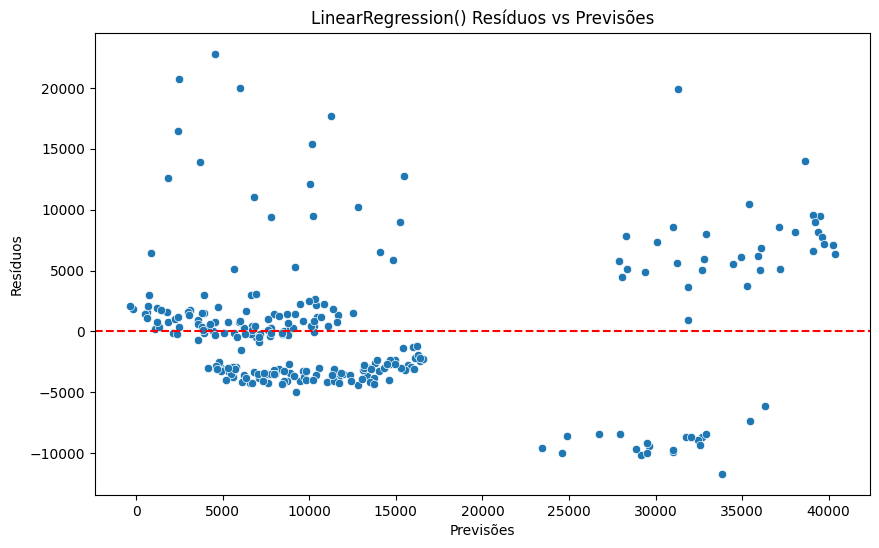

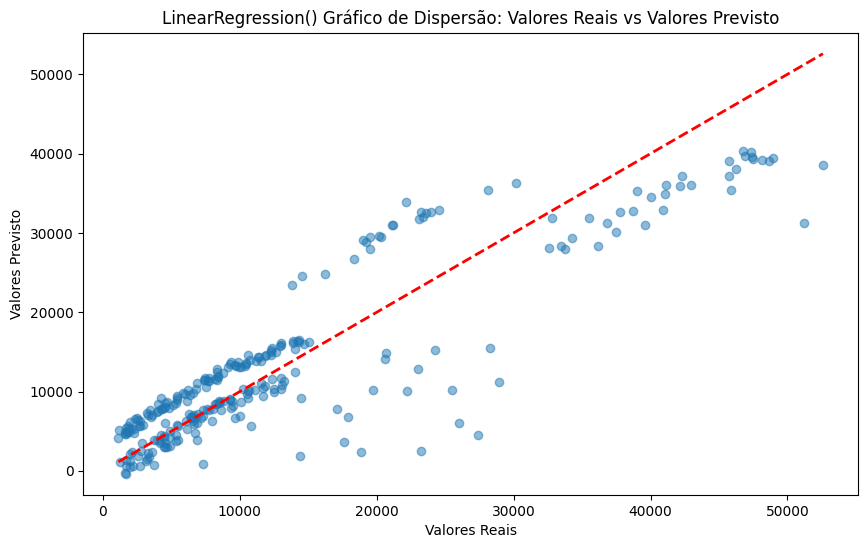

Avaliação do Modelo: LinearRegression()
Erro Absoluto Médio (MAE): 4101.795298155489
Erro Quadrático Médio (MSE): 32288223.845232166
Raiz do Erro Quadrático Médio (RMSE): 5682.272771104197
MAPE: 45.22410983407713 %
R²: 0.7970952586548639


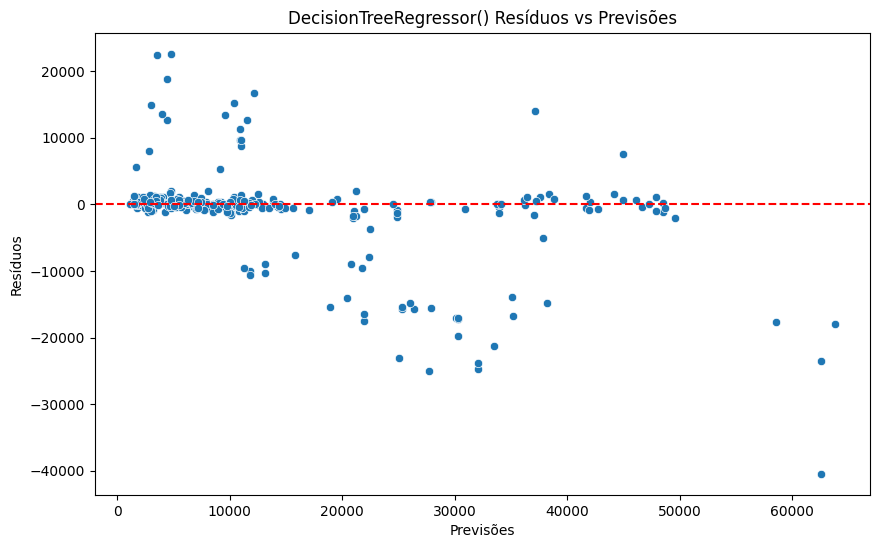

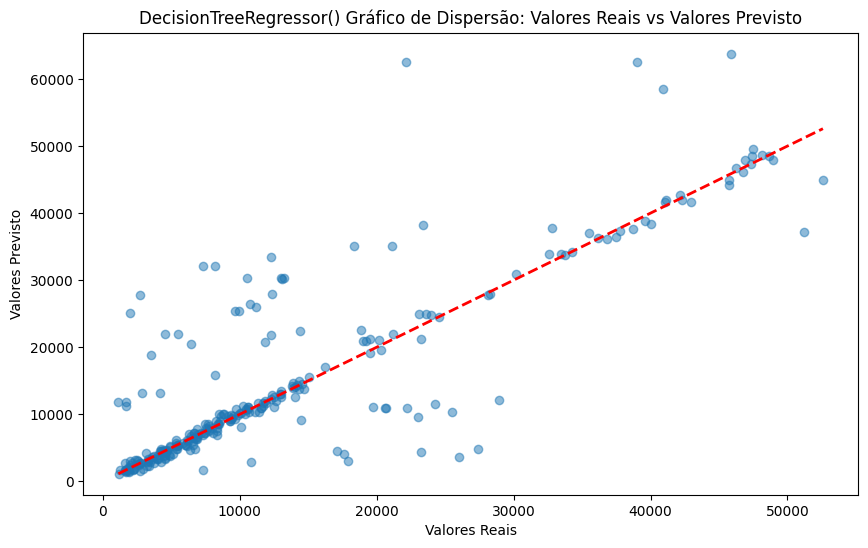

Avaliação do Modelo: DecisionTreeRegressor()
Erro Absoluto Médio (MAE): 3474.5433689514925
Erro Quadrático Médio (MSE): 53320491.35253525
Raiz do Erro Quadrático Médio (RMSE): 7302.088150148234
MAPE: 44.62556785041189 %
R²: 0.6649248791714097


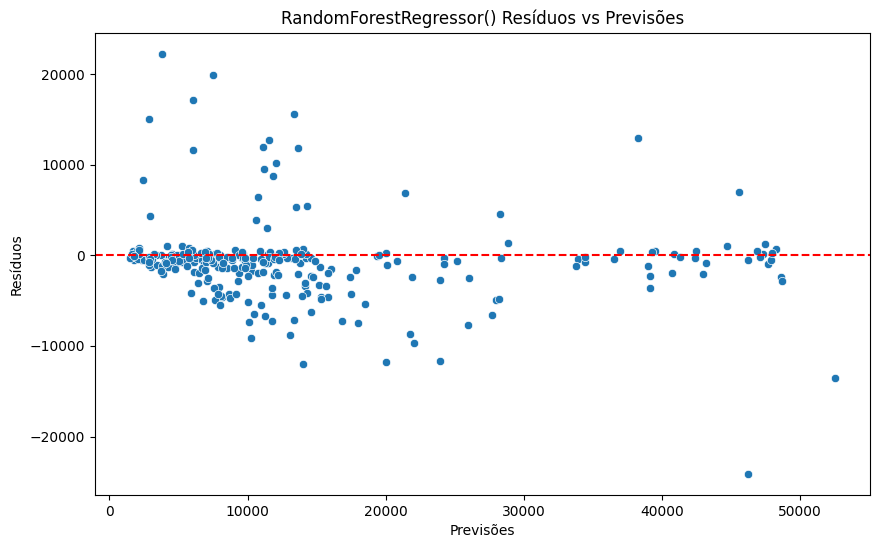

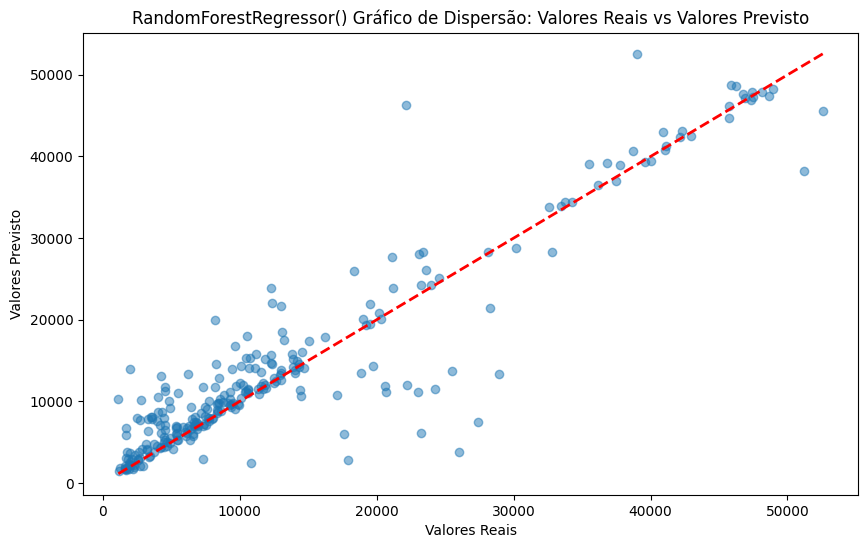

Avaliação do Modelo: RandomForestRegressor()
Erro Absoluto Médio (MAE): 2655.9484085476674
Erro Quadrático Médio (MSE): 21890812.737095933
Raiz do Erro Quadrático Médio (RMSE): 4678.761880785977
MAPE: 35.77018855177606 %
R²: 0.8624343749118565


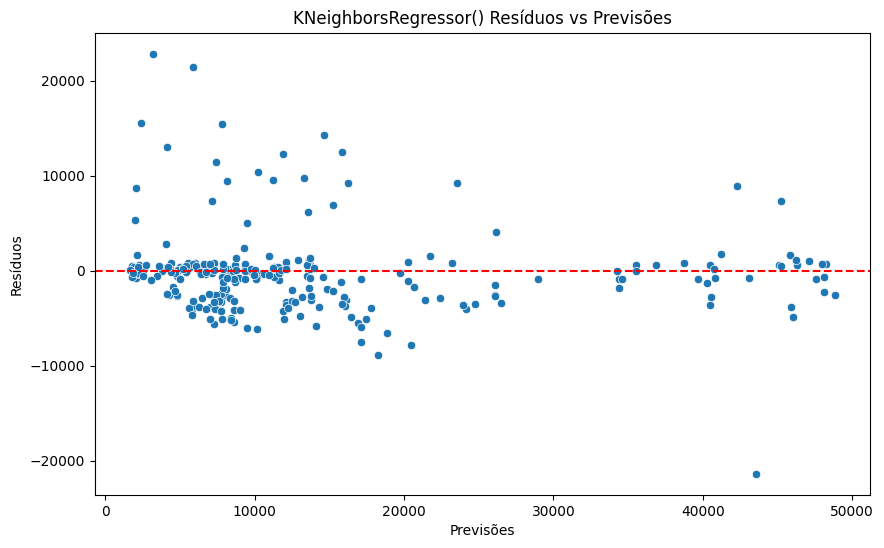

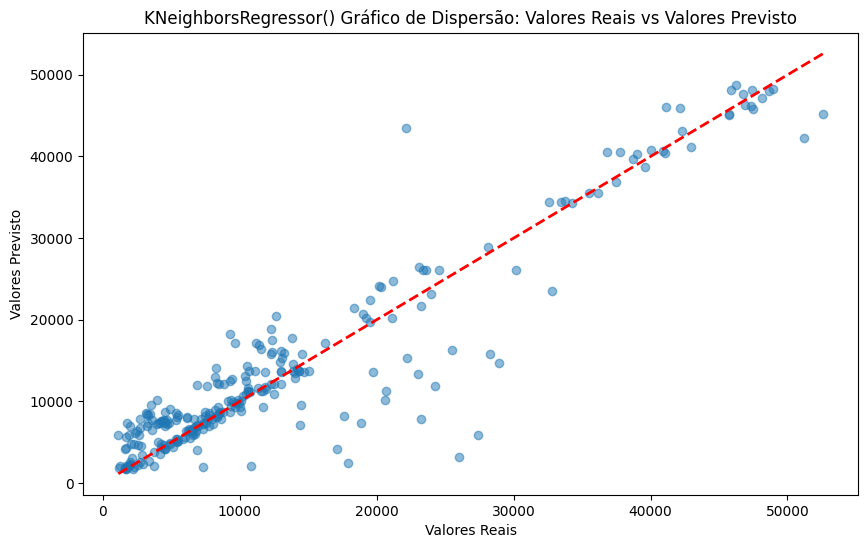

Avaliação do Modelo: KNeighborsRegressor()
Erro Absoluto Médio (MAE): 2628.3584441231346
Erro Quadrático Médio (MSE): 19487061.310373407
Raiz do Erro Quadrático Médio (RMSE): 4414.4151719535175
MAPE: 35.23143763218527 %
R²: 0.877539961513182


In [56]:
models = [
    LinearRegression(), 
    DecisionTreeRegressor(), 
    RandomForestRegressor(n_estimators=100),
    KNeighborsRegressor(n_neighbors=5)
]

for model in models:
    predict_and_evaluate(model, X_test, X_train, y_test, y_train)

<<Explicação>>

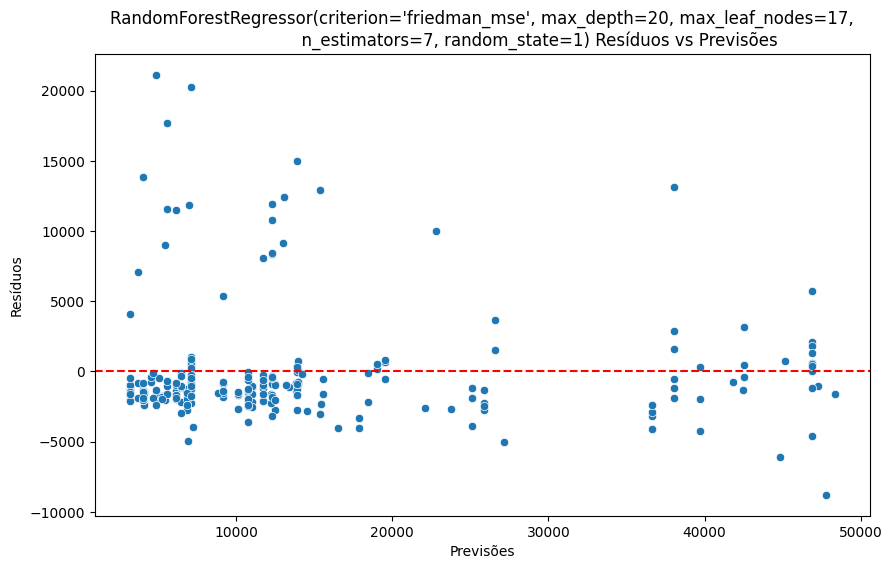

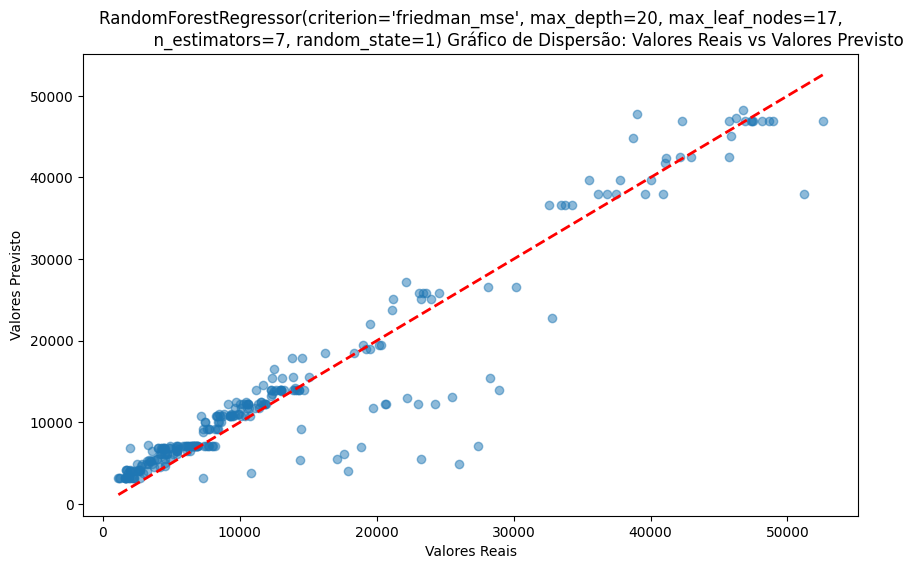

Avaliação do Modelo: RandomForestRegressor(criterion='friedman_mse', max_depth=20, max_leaf_nodes=17,
                      n_estimators=7, random_state=1)
Erro Absoluto Médio (MAE): 2393.7231158087056
Erro Quadrático Médio (MSE): 15811264.726478495
Raiz do Erro Quadrático Médio (RMSE): 3976.3381051513334
MAPE: 30.37086731377442 %
R²: 0.9006392982455946


In [57]:
model = RandomForestRegressor(n_estimators=7, max_depth=20, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1)
predict_and_evaluate(model, X_test, X_train, y_test, y_train)

Eli5 - Monstrando os atributos que tem relevancia para o modelo

In [58]:
import eli5
colunas = preprocessor.get_feature_names_out()
eli5.show_weights(model, feature_names = colunas)

Weight,Feature
0.4869 ± 0.6175,cat__smoker_yes
0.1899 ± 0.6004,cat__smoker_no
0.1892 ± 0.0286,num__bmi
0.1247 ± 0.0211,num__age
0.0091 ± 0.0055,num__children
0.0003 ± 0.0013,cat__weight_condition_Overweight
0 ± 0.0000,cat__weight_condition_Underweight
0 ± 0.0000,cat__weight_condition_Normal Weight
0 ± 0.0000,cat__weight_condition_Obese


<<Explicação>>

In [59]:
from eli5 import show_prediction
from sklearn.calibration import LabelEncoder

previsores = data.iloc[:, :-1].values
labelencoder = LabelEncoder()
for i in range(previsores.shape[1]):
  if previsores[:,i].dtype == 'object':
    previsores[:,i] = labelencoder.fit_transform( previsores[:,i])
    
eli5.show_prediction(model, previsores[1], feature_names = colunas, show_feature_values=True)

/home/lucas/Study/projects/IA-Studies/venv/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


<<Explicação>>

Montagem do Modelo Final... foco em Criar o Pipeline e o arquivo do Modelo

In [60]:
import pickle
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class WeightConditionTransformer(BaseEstimator, TransformerMixin):

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["weight_condition"] = ""
        X.loc[X["bmi"] < 18.5, "weight_condition"] = "Underweight"
        X.loc[(X["bmi"] >= 18.5) & (X["bmi"] < 25), "weight_condition"] = "Normal Weight"
        X.loc[(X["bmi"] >= 25) & (X["bmi"] < 30), "weight_condition"] = "Overweight"
        X.loc[X["bmi"] >= 30, "weight_condition"] = "Obese"
        return X

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), ['age', 'bmi', 'children']), # numeric features
    ('cat', OneHotEncoder(), ['smoker', "weight_condition"]) # categorical features
])

pipeline = Pipeline(steps=[
    ('add_weight_condition', WeightConditionTransformer()), # Adiciona a coluna weight_condition
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=7, max_depth=20, max_leaf_nodes=17, criterion = 'friedman_mse', random_state = 1))
])

data = pd.read_csv("dados/insurance.csv")
data = data.drop(['region'], axis='columns')  # A Coluna Região não é relevante para o modelo
data = data.drop(['sex'], axis='columns')  # A Coluna Sexo não é relevante para o modelo


X = data.drop(['charges'], axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
pipeline.fit(X_train, y_train)

with open('wcmodel.pkl', 'wb') as f:
    pickle.dump(pipeline, f)
    
pipeline

Pipeline(steps=[('add_weight_condition', WeightConditionTransformer()),
                ('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'bmi', 'children']),
                                                 ('cat', OneHotEncoder(),
                                                  ['smoker',
                                                   'weight_condition'])])),
                ('model',
                 RandomForestRegressor(criterion='friedman_mse', max_depth=20,
                                       max_leaf_nodes=17, n_estimators=7,
                                       random_state=1))])

<<Explicação>>

In [61]:
features = pd.DataFrame([['no', 33,25, 0]], columns=['smoker', 'age', 'bmi', 'children'])
result = pipeline.predict(features)
print(f"Predicted insurance cost: {result}")

Predicted insurance cost: [6172.02456359]


explicação .... 

In [63]:
import os
from pydantic import BaseModel


class InsuranceData(BaseModel):
    smoker: str
    age: int
    bmi: float
    children: int
    

class WealthCostPrediction:
    
    def __init__(self):
        self.model_path = 'wcmodel.pkl'
        self.pipeline = None
        
    def predict(self, features):
        if not os.path.exists(self.model_path):
            raise FileNotFoundError(f"Model file '{self.model_path}' not found. Please train the model first.")
        
        with open(self.model_path, 'rb') as f:
            self.pipeline = pickle.load(f)
        
        if not isinstance(features, pd.DataFrame):
            features = pd.DataFrame([features], columns=['smoker', 'age', 'bmi', 'children'])
        
        prediction = self.pipeline.predict(features)
        return round(float(prediction[0]), 2)
        


features = InsuranceData(smoker='no', age=33, bmi=25, children=0)


prediction = WealthCostPrediction()
result = prediction.predict([features.smoker, features.age, features.bmi, features.children])
print(f"Predicted insurance cost: {result}")


Predicted insurance cost: 6172.02
